In [ ]:
# prompt: create connect drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/liveness_detection

In [ ]:
!pip install pillow

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array

2024-11-30 10:45:21.729825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732938321.864698     914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732938321.903032     914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 10:45:22.209347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# prompt: create version of tensorflow gpu

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


In [11]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asgiref                      3.8.1
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.4.0
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.8
decorator                    5.1.1
Django                       5.1.3
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  24.3.25
fonttools                    4.55.0
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.68.0
h5py                         3.12.1
idna                         3.10
image                        1.5.33
ipykernel                    6.29.5
ipython                      8.29.0
jedi                         0.19.2
joblib                       1.4.2

In [2]:
# Direktori dataset
DATASET_DIR = "../datasets/datasets/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
TRAIN_SET = os.path.join(DATASET_DIR, "train_front_facing_set")
TEST_SET = os.path.join(DATASET_DIR, "test_front_facing_set")

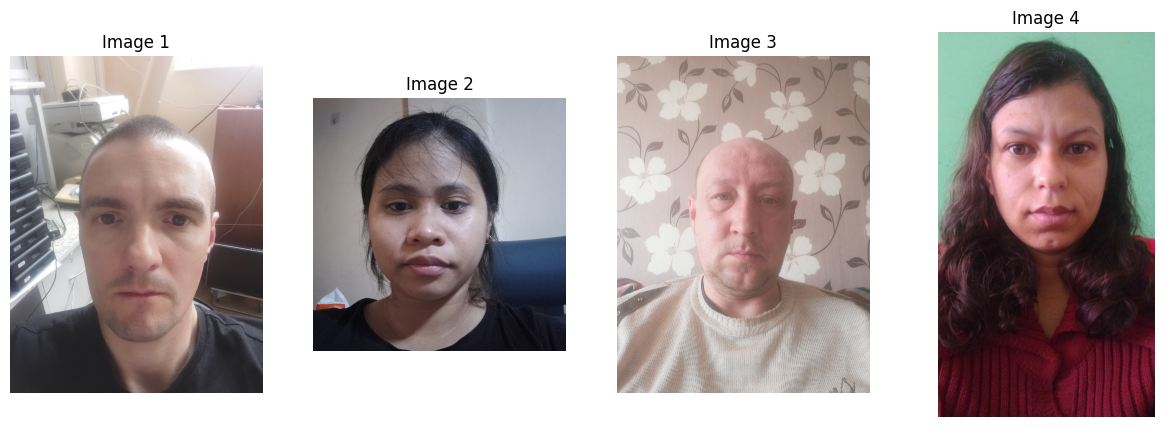

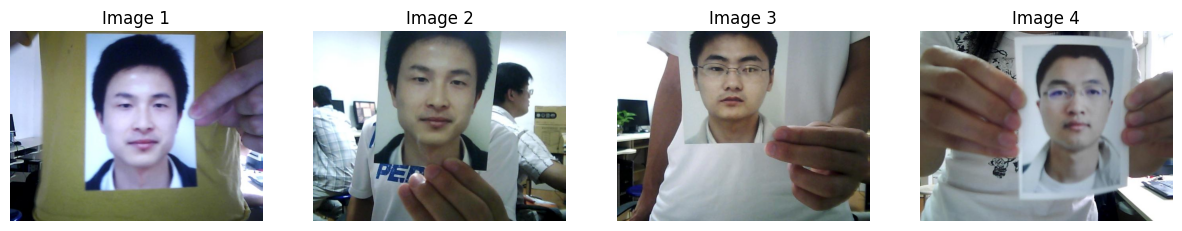

In [4]:
# Fungsi untuk menampilkan gambar
def show_images(directory, num_images=5):
  """Menampilkan beberapa gambar dari direktori yang diberikan.

  Args:
    directory: Path ke direktori yang berisi gambar.
    num_images: Jumlah gambar yang akan ditampilkan.
  """
  image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
  fig, axes = plt.subplots(1, min(num_images, len(image_files)), figsize=(15, 5))
  for i, ax in enumerate(axes):
      if i < len(image_files):
          image_path = os.path.join(directory, image_files[i])
          img = mpimg.imread(image_path)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Image {i+1}")
  plt.show()

# Menampilkan 4 gambar dari direktori "real" dalam dataset
front_facing = os.path.join(TRAIN_SET, "front_facing")
show_images(front_facing, num_images=4)

# Menampilkan 4 gambar dari direktori "fake" dalam dataset
attack = os.path.join(TRAIN_SET, "attack")
show_images(attack, num_images=4)


In [5]:
# prompt: buat mengambil gambar dari directory attack dan liveness lalu gambar tersebut di augmentasi dan selanjunya ditampilkan beberapa gambar(original, augmentasi 1 sampai 3
# Pilih satu gambar secara acak dari direktori attack dan liveness
attack = os.path.join(TRAIN_SET, 'attack')
front_facing = os.path.join(TRAIN_SET, 'front_facing')

attack_images = [os.path.join(attack, f) for f in os.listdir(attack) if os.path.isfile(os.path.join(attack, f))]
front_facing_images = [os.path.join(front_facing, f) for f in os.listdir(front_facing) if os.path.isfile(os.path.join(front_facing, f))]

random_attack_image_path = random.choice(attack_images)
random_front_facing_image_path = random.choice(front_facing_images)

image_paths = [random_attack_image_path, random_front_facing_image_path]

In [8]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fungsi untuk melakukan cropping pada gambar
def crop_center(image, cropx, cropy):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty+cropy, startx:startx+cropx]

# Fungsi preprocessing yang menggabungkan cropping dan preprocessing MobileNetV3
def preprocess_and_crop(image):
    image = img_to_array(image)
    image = crop_center(image, 224, 224)
    image = preprocess_input(image)
    return image

In [17]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_crop,
    validation_split=0.2,
    brightness_range=[0.7, 1.3],
    # horizontal_flip=True,
    # vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    fill_mode='nearest',
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_and_crop)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_SET,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 1202 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [ ]:
# Load dan augmentasi gambar
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i, img_path in enumerate(image_paths):
  img = load_img(img_path)
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  # Buat ImageDataGenerator untuk augmentasi
  datagen = train_datagen

  # Generate gambar augmentasi
  augmented_images = [next(datagen.flow(x, batch_size=1))[0] for _ in range(3)]

  # Tampilkan gambar original dan augmentasi
  axes[i, 0].imshow(img)
  axes[i, 0].set_title(f"Original Image {i+1} ({'attack' if i == 0 else 'liveness'})")
  axes[i, 0].axis('off')

  for j, augmented_image in enumerate(augmented_images):
    axes[i, j+1].imshow(augmented_image.astype('uint8'))
    axes[i, j+1].set_title(f"Augmented Image {j+1}")
    axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Model Transfer Learning dengan EfficientNetB_

# from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
x = MaxPooling2D(2, 2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
# # Model with MObileNetV3

# from tensorflow.keras.applications import MobileNetV3Small
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.layers import Flatten, Dropout

# base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# x = base_model.output
# x = Conv2D(128, (3, 3), activation='relu', padding='same',
#            kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01))(x)
# x = MaxPooling2D(2, 2)(x)
# x = GlobalAveragePooling2D()(x)
# # x = Dense(1024, activation='relu')(x)
# x = Flatten()(x)
# x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
# x = Dropout(0.2)(x)
# output = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=output)

# # Fine-tuning
# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy', 'Precision', 'Recall'])

In [ ]:
# model.summary()

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            if acc >= 0.99 and val_acc >= 0.98999:
                print("\nReached target accuracy, stopping training...")
                self.model.stop_training = True

In [21]:
# Callback
checkpoint_path = "../model_download/front_facing/model_front_facing4.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# custom_callback = CustomCallback()

In [22]:
# Training
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint,
               early_stopping,
              #  custom_callback,
               lr_scheduler]
)

Epoch 1/25


2024-11-30 11:11:23.174877: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3328_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-30 11:11:24.480880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336', 220 bytes spill stores, 220 bytes spill loads

2024-11-30 11:11:25.570797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336_0', 88 bytes spill stores, 120 bytes spill loads

2024-11-30 11:11:25.867663: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8588', 60 bytes spill stores, 64 bytes spill loads

2024-11-30 11:11:26.139752: I external/local_xla/xla/st

12/38 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Precision: 0.5421 - Recall: 0.4940 - accuracy: 0.5534 - loss: 16.9747

2024-11-30 11:11:47.771698: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336_0', 352 bytes spill stores, 448 bytes spill loads

2024-11-30 11:11:48.440387: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336', 4 bytes spill stores, 4 bytes spill loads

2024-11-30 11:11:50.096420: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8590', 24 bytes spill stores, 24 bytes spill loads

2024-11-30 11:11:50.519889: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8588', 32 bytes spill stores, 32 bytes spill loads

2024-11-30 11:11:50.553701: I external/local_xla/xla/strea

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.6194 - Recall: 0.6116 - accuracy: 0.6211 - loss: 16.4994

2024-11-30 11:12:36.095944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1390', 4 bytes spill stores, 4 bytes spill loads

2024-11-30 11:12:36.829368: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1398', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.67881, saving model to ../model_download/front_facing/model_front_facing4.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - Precision: 0.6209 - Recall: 0.6149 - accuracy: 0.6229 - loss: 16.4827 - val_Precision: 0.6107 - val_Recall: 0.9868 - val_accuracy: 0.6788 - val_loss: 14.6796 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.7459 - Recall: 0.8569 - accuracy: 0.7736 - loss: 14.0632
Epoch 2: val_accuracy improved from 0.67881 to 0.89404, saving model to ../model_download/front_facing/model_front_facing4.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - Precision: 0.7464 - Recall: 0.8567 - accuracy: 0.7741 - loss: 14.0494 - val_Precision: 0.8480 - val_Recall: 0.9603 - val_accuracy: 0.8940 - val_loss: 12.3884 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.8214 - Recall: 0.8673 - accuracy: 0.8395 - loss: 11.9833
Epoch 3: val_accuracy improved from 0.89404 to 0

In [24]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - Precision: 0.8991 - Recall: 0.9699 - accuracy: 0.9348 - loss: 1.2568
Loss: 1.260305404663086, Accuracy: 0.9370861053466797, Precision: 0.9125000238418579, Recall: 0.9668874144554138


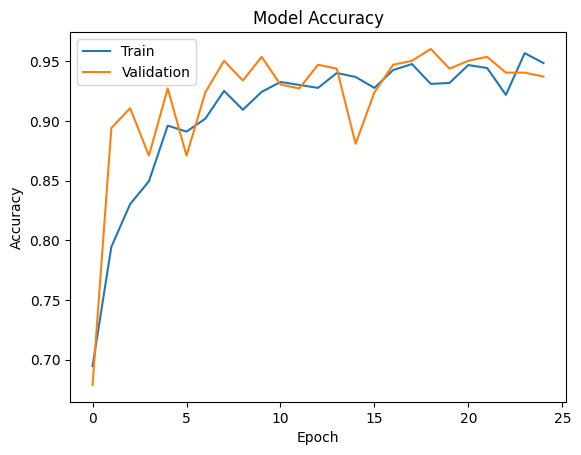

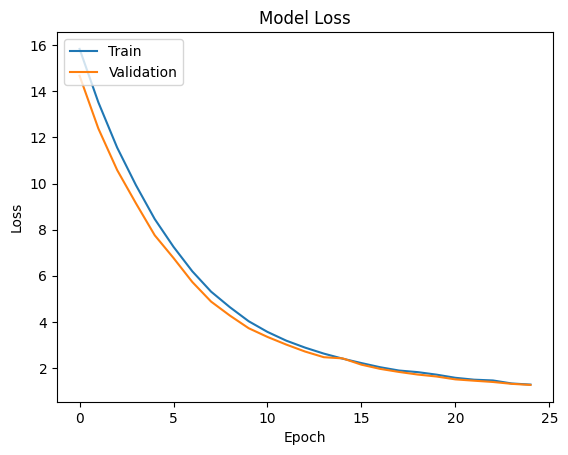

In [25]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Mendapatkan prediksi dari model pada data validasi
y_pred = model.predict(val_data)
y_pred_classes = np.round(y_pred)

# Mendapatkan label sebenarnya dari data validasi
y_true = val_data.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualisasi confusion matrix (opsional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Attack', 'Liveness'], yticklabels=['Attack', 'Liveness'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../datasets/pictures/model_download/model_front_facing.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Example usage:
test_image_path = "/content/drive/MyDrive/liveness_detection/datasets/test/0001_00_01_03_77.jpg" # Replace with the path to your test image

preprocessed_image = preprocess_image(test_image_path)
prediction = model.predict(preprocessed_image)

if prediction[0][0] > 0.5:
  print("Prediction: Liveness")
else:
  print("Prediction: Attack")

# You can also get the confidence score
print(f"Confidence score: {prediction[0][0]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction: Attack
Confidence score: 0.9819


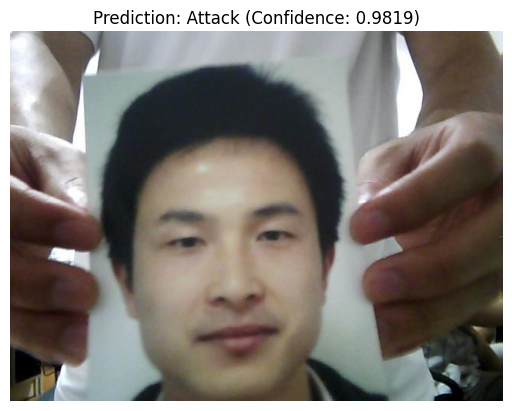

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Liveness
Confidence score: 0.9904


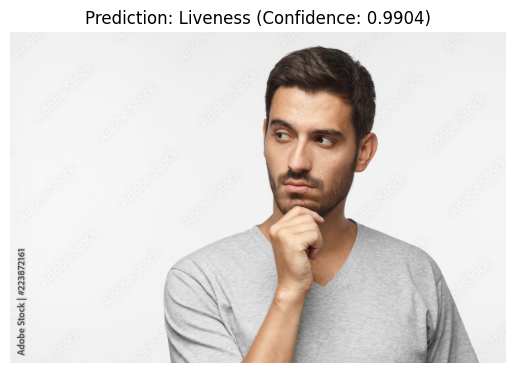

In [26]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/front_facing/model_front_facing4.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Function to predict and display results
def predict_image(image_path):
  preprocessed_image = preprocess_image(image_path)
  prediction = model.predict(preprocessed_image)

  if prediction[0][0] > 0.5:
    label = "Liveness"
  else:
    label = "Attack"

  confidence = prediction[0][0] if label == "Liveness" else 1 - prediction[0][0]

  print(f"Prediction: {label}")
  print(f"Confidence score: {confidence:.4f}")
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
  plt.axis('off')
  plt.show()


# Example usage:
test_image_path1 = "../datasets/test/test/0001_00_01_03_77.jpg"
test_image_path2 = "../datasets/test/test/1000_F_223872161_YZ98dGUBv8Oh7ce3WgF4JRbT9u07Nv4m.jpg"


predict_image(test_image_path1)
predict_image(test_image_path2)


In [30]:
# COnvert to tflite

model = tf.keras.models.load_model('../model_download/front_facing/model_front_facing4.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()

tflite_model_path = '../datasets/pictures/model_download/model_front_facing4.tflite' 
with open(tflite_model_path, 'wb') as f: 
    f.write(tflite_model) 
    
print(f"Model converted and saved to {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmpofmkh87c/assets


INFO:tensorflow:Assets written to: /tmp/tmpofmkh87c/assets


Saved artifact at '/tmp/tmpofmkh87c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139825670446368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670473328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670475440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670452176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670454464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670481952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670482128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670483712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825670484416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398256704854

W0000 00:00:1732942553.322018     914 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732942553.322606     914 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-30 11:55:53.331323: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpofmkh87c
2024-11-30 11:55:53.336792: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 11:55:53.336825: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpofmkh87c
I0000 00:00:1732942553.473439     914 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-30 11:55:53.490801: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 11:55:54.073986: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpofmkh87c
2024-11-30 11:55:54.208942: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model converted and saved to ../datasets/pictures/model_download/model_front_facing4.tflite


In [32]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/front_facing/model_front_facing4.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/front_facing/model_front_facing_quant4.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpkr4nctiq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkr4nctiq/assets


Saved artifact at '/tmp/tmpkr4nctiq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139825649546896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649459168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649461280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649454592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649456880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649462864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649418832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649420416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139825649421120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398256494265

W0000 00:00:1732943098.078901     914 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732943098.078976     914 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-30 12:04:58.079474: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkr4nctiq
2024-11-30 12:04:58.087994: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-30 12:04:58.088040: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkr4nctiq
2024-11-30 12:04:58.245067: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-30 12:04:58.979535: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkr4nctiq
2024-11-30 12:04:59.138618: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1059171 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt

# Memuat model TFLite
tflite_model_path = '../model_download/front_facing/model_front_facing_quant4.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk memproses gambar
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Fungsi untuk melakukan prediksi
def predict_image(image):
    preprocessed_image = preprocess_image(image)
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Mengambil gambar dari kamera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open camera.")
else:
    ret, frame = cap.read()
    if ret:
        # Menampilkan gambar yang diambil
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Melakukan prediksi
        prediction = predict_image(frame)
        confidence = prediction[0][0]
        label = "Attack" if confidence > 0.5 else "Liveness"
        confidence = confidence if label == "Right" else 1 - confidence

        print(f"Prediction: {label}")
        print(f"Confidence score: {confidence:.4f}")
    else:
        print("Error: Could not read frame from camera.")
    cap.release()

Error: Could not open camera.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
[ WARN:0@0.197] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.198] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


: 